# ARIMA model for predict today's tesla stock price (yejin)

- reference 

: https://www.youtube.com/watch?v=rsva2qmhGyE (Predict Stock Price using ARIMA model (Python))

: https://www.youtube.com/watch?v=gqryqIlvEoM (How to Choose the p, d, q Terms to Build ARIMA Model)

- book 52p (pdf 77p) : identifying MA order by looking ACF. 
- book 59p : EACF for ARMA 
- book 68p : Differncing(ARIMA)



- using thesis (python 3.9.21) env : conda activate thesis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
import datetime
import warnings

warnings.filterwarnings("ignore")

In [2]:
#import tesla data

ticker = 'TSLA'
data = yf.Ticker(ticker)
data

yfinance.Ticker object <TSLA>

In [3]:
import yfinance as yf

# TSLA 데이터 요청 (debug mode 없이)
data = yf.Ticker("TSLA")
prices = data.history(period="2y")

print(prices.head())  # 정상적으로 데이터 나오는지 확인!


                                 Open        High         Low       Close  \
Date                                                                        
2023-03-01 00:00:00-05:00  206.210007  207.199997  198.520004  202.770004   
2023-03-02 00:00:00-05:00  186.740005  193.750000  186.009995  190.899994   
2023-03-03 00:00:00-05:00  194.800003  200.479996  192.880005  197.789993   
2023-03-06 00:00:00-05:00  198.539993  198.600006  192.300003  193.809998   
2023-03-07 00:00:00-05:00  191.380005  194.199997  186.100006  187.710007   

                              Volume  Dividends  Stock Splits  
Date                                                           
2023-03-01 00:00:00-05:00  156852800        0.0           0.0  
2023-03-02 00:00:00-05:00  181500700        0.0           0.0  
2023-03-03 00:00:00-05:00  154193300        0.0           0.0  
2023-03-06 00:00:00-05:00  128100100        0.0           0.0  
2023-03-07 00:00:00-05:00  148125800        0.0           0.0  


In [4]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=730)
tomorrow = end_date + datetime.timedelta(days=1)
prices = data.history(start=start_date,end=end_date).Close
prices

Date
2023-03-03 00:00:00-05:00    197.789993
2023-03-06 00:00:00-05:00    193.809998
2023-03-07 00:00:00-05:00    187.710007
2023-03-08 00:00:00-05:00    182.000000
2023-03-09 00:00:00-05:00    172.919998
                                ...    
2025-02-24 00:00:00-05:00    330.529999
2025-02-25 00:00:00-05:00    302.799988
2025-02-26 00:00:00-05:00    290.799988
2025-02-27 00:00:00-05:00    281.950012
2025-02-28 00:00:00-05:00    292.980011
Name: Close, Length: 500, dtype: float64

In [5]:
print(end_date)
print(tomorrow)

2025-03-02
2025-03-03


In [6]:
prices.describe()

count    500.000000
mean     240.468580
std       68.661637
min      142.050003
25%      187.335003
50%      228.970001
75%      259.355003
max      479.859985
Name: Close, dtype: float64

In [7]:
#calculate returns
returns = prices.pct_change().dropna()
returns

Date
2023-03-06 00:00:00-05:00   -0.020122
2023-03-07 00:00:00-05:00   -0.031474
2023-03-08 00:00:00-05:00   -0.030419
2023-03-09 00:00:00-05:00   -0.049890
2023-03-10 00:00:00-05:00    0.003007
                               ...   
2025-02-24 00:00:00-05:00   -0.021522
2025-02-25 00:00:00-05:00   -0.083896
2025-02-26 00:00:00-05:00   -0.039630
2025-02-27 00:00:00-05:00   -0.030433
2025-02-28 00:00:00-05:00    0.039120
Name: Close, Length: 499, dtype: float64

Text(0, 0.5, 'Returns')

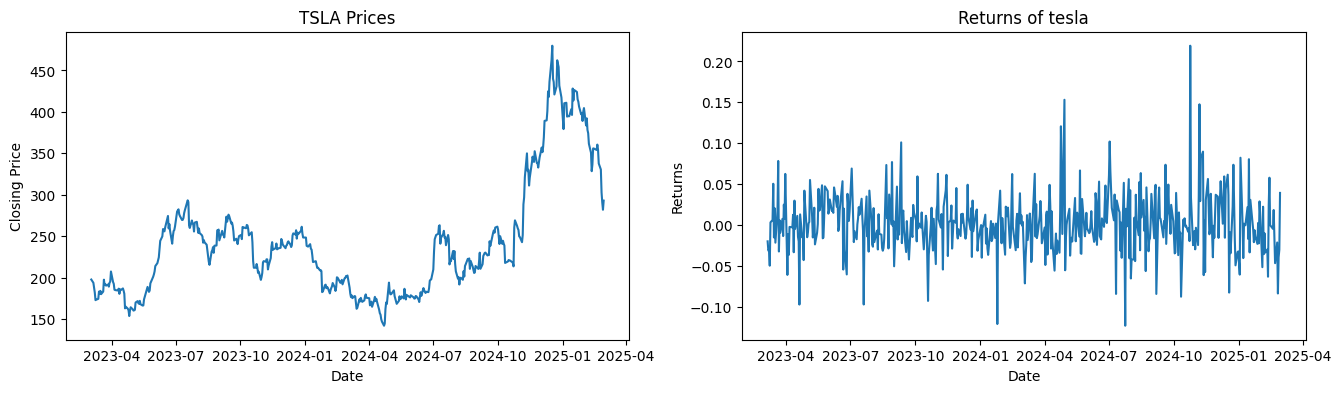

In [8]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(prices)
ax1.set_title("TSLA Prices")
ax1.set_xlabel("Date")
ax1.set_ylabel("Closing Price")

ax2.plot(returns)
ax2.set_title("Returns of tesla")
ax2.set_xlabel("Date")
ax2.set_ylabel("Returns")

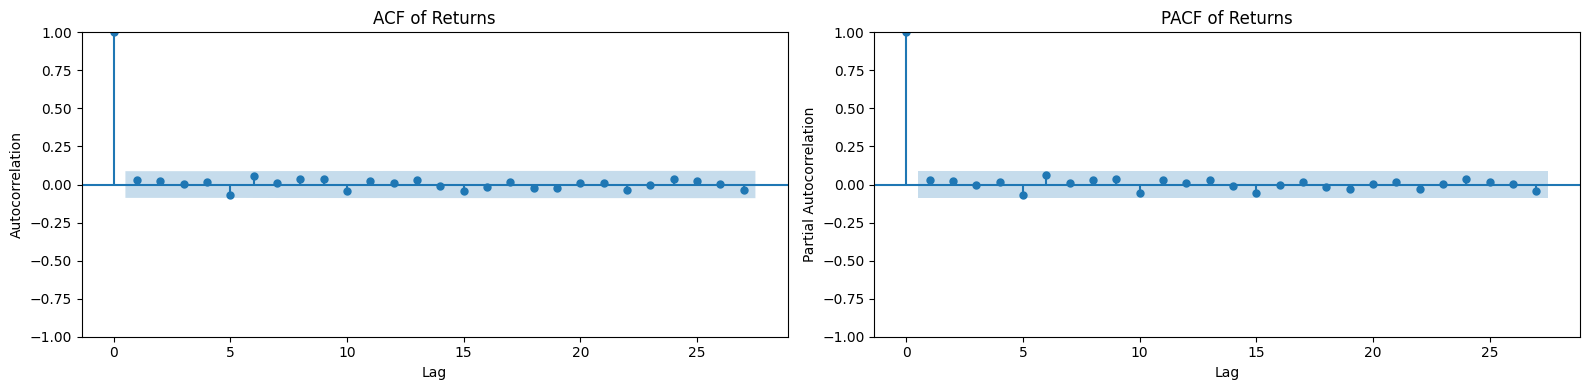

In [9]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# ACF Plot
plot_acf(returns, ax=ax1)
ax1.set_title("ACF of Returns")
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelation")

# PACF Plot
plot_pacf(returns, ax=ax2, method='ywm')
ax2.set_title("PACF of Returns")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Partial Autocorrelation")

plt.tight_layout()
plt.show()

# Stationary 

### ADF test (Augumented Dickey Fuller test) to check if the price series is stationary. 

Null hypothesis of the ADF test : time series is non-stationary.
So, if the p-value of the test is less than the significance level(0.05) then we can reject the null hypothesis and fer that time series is indeed stationary. 

In [10]:
#check if price series is stationary 
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -1.4644415963523023
p-value: 0.5510225573190878


### interpretation : p-value is clearly high, it means this time series is non stationary.
in our case, the p-value > 0.05 we'll need fo find the order of differencing.

ADF Statistic: -1.4376054898643604, p-value: 0.5641207790120272


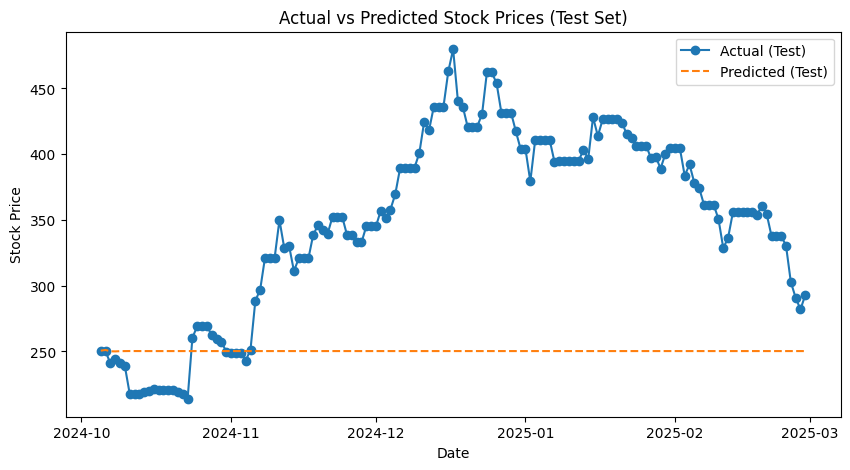

RMSE: 120.70
MAPE: 27.51%
MAE: 104.49


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load TSLA price data
ticker = "TSLA"
prices = yf.Ticker(ticker).history(period="2y").Close

# Ensure datetime format and fill missing values
prices.index = pd.to_datetime(prices.index)
prices = prices.asfreq('D').ffill()

# ADF test to check stationarity
adf_result = adfuller(prices.dropna())
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")

# Apply differencing if needed
if adf_result[1] > 0.05:
    prices_diff = prices.diff().dropna()
else:
    prices_diff = prices

# Train/test split
train_size = int(len(prices) * 0.8)
train, test = prices[:train_size], prices[train_size:]

# Manually set ARIMA order (p, d, q)
model_order = (5,1,0)  # Manually chosen

# Train the ARIMA model
model = ARIMA(train, order=model_order)
fitted = model.fit()

# Generate predictions
predictions = fitted.forecast(steps=len(test))
predictions = pd.Series(predictions, index=test.index)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label="Actual (Test)", marker="o")
plt.plot(predictions.index, predictions, label="Predicted (Test)", linestyle="dashed")
plt.title("Actual vs Predicted Stock Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Compute evaluation metrics
errors = predictions - test
rmse = np.sqrt(np.mean(np.square(errors)))
mape = np.mean(np.abs(errors / test)) * 100
mae = np.mean(np.abs(errors))

# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")


In [12]:
predictions = fitted.forecast(steps=len(test))
print(predictions.head())  # Check if values are NaN


2024-10-05 00:00:00-04:00    250.596717
2024-10-06 00:00:00-04:00    251.191873
2024-10-07 00:00:00-04:00    250.449137
2024-10-08 00:00:00-04:00    250.557586
2024-10-09 00:00:00-04:00    250.487710
Freq: D, Name: predicted_mean, dtype: float64


In [13]:
print(fitted.summary())  # Check model parameters


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  584
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1866.206
Date:                Sun, 02 Mar 2025   AIC                           3742.412
Time:                        16:02:09   BIC                           3764.253
Sample:                    03-01-2023   HQIC                          3750.925
                         - 10-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1830      0.639     -0.287      0.774      -1.435       1.069
ar.L2          0.0129      0.052      0.246      0.806      -0.090       0.116
ar.L3         -0.0680      0.057     -1.185      0.2

In [14]:
#prediction the next day price
next_day_price = fitted.forecast(100,alpha=0.05) # next 100days prediction, 95% of confidence level 
print(next_day_price)

2024-10-05 00:00:00-04:00    250.596717
2024-10-06 00:00:00-04:00    251.191873
2024-10-07 00:00:00-04:00    250.449137
2024-10-08 00:00:00-04:00    250.557586
2024-10-09 00:00:00-04:00    250.487710
                                ...    
2025-01-08 00:00:00-05:00    250.537109
2025-01-09 00:00:00-05:00    250.537109
2025-01-10 00:00:00-05:00    250.537109
2025-01-11 00:00:00-05:00    250.537109
2025-01-12 00:00:00-05:00    250.537109
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


In [15]:
predicted_price= next_day_price.values[0]
print(f"The predicted_price for {tomorrow} tomorrow:", predicted_price)

The predicted_price for 2025-03-03 tomorrow: 250.59671656361718


<!-- ### Train test split --> -->

In [16]:
from pmdarima import auto_arima
auto_arima(train, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3746.046, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3739.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3741.329, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3741.329, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3737.439, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3743.328, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.280 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Total data length: 731
Train data length: 584
Test data length: 147
Date
2024-10-05 00:00:00-04:00    250.596717
2024-10-06 00:00:00-04:00    251.191873
2024-10-07 00:00:00-04:00    250.449137
2024-10-08 00:00:00-04:00    250.557586
2024-10-09 00:00:00-04:00    250.487710
Freq: D, Name: predicted_mean, dtype: float64
...
Date
2025-02-24 00:00:00-05:00    250.537109
2025-02-25 00:00:00-05:00    250.537109
2025-02-26 00:00:00-05:00    250.537109
2025-02-27 00:00:00-05:00    250.537109
2025-02-28 00:00:00-05:00    250.537109
Freq: D, Name: predicted_mean, dtype: float64


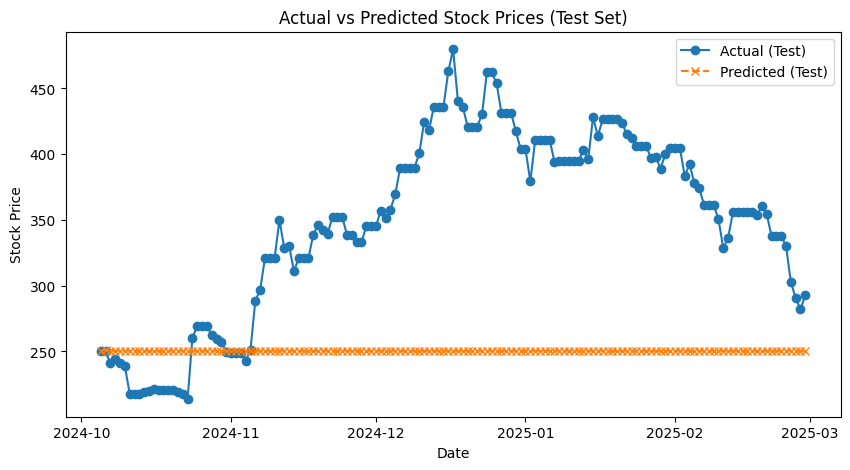

RMSE: 120.48
MAPE: 27.46%
MAE:  104.31


In [17]:
# Split the dataset into 80% train and 20% test
train_size = int(len(prices) * 0.8)
train = prices[:train_size]   # First 80% as training data
test = prices[train_size:]    # Remaining 20% as test data

print(f"Total data length: {len(prices)}")
print(f"Train data length: {len(train)}")
print(f"Test data length: {len(test)}")

# Train ARIMA model on the training dataset (example: (p,d,q) = (0,1,0))
model = ARIMA(train, order=(3,1,1))
fitted = model.fit()

# Generate predictions for the test period
predictions = fitted.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
predictions = pd.Series(predictions, index=test.index)

print(predictions.head())    # Display first few predictions
print("...")  
print(predictions.tail())    # Display last few predictions

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual (Test)', marker='o')
plt.plot(predictions.index, predictions, label='Predicted (Test)', marker='x', linestyle="dashed")
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Calculate prediction errors
errors = predictions - test

# Compute evaluation metrics
rmse = np.sqrt(np.mean(np.square(errors)))  # Root Mean Squared Error
mape = np.mean(np.abs(errors / test)) * 100  # Mean Absolute Percentage Error
mae  = np.mean(np.abs(errors))  # Mean Absolute Error

# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE:  {mae:.2f}")


Total data length: 731
Train data length: 584
Test data length: 147


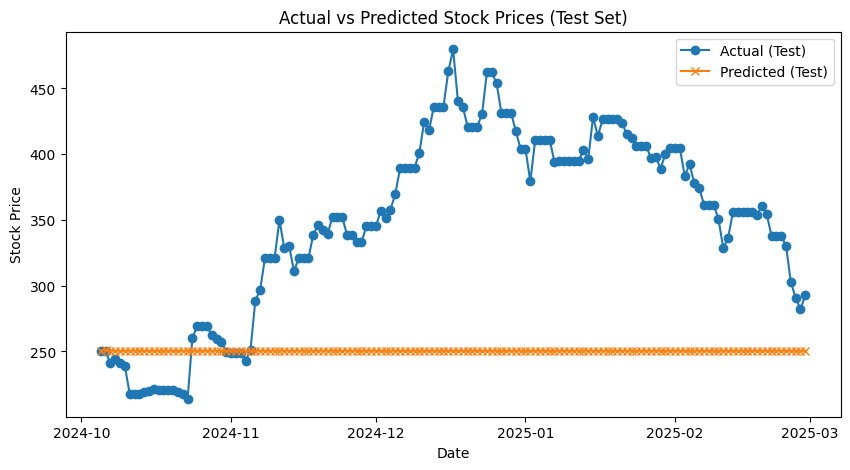

RMSE: 120.48
MAPE: 27.46%
MAE:  104.31


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Ensure the dataset has a proper DateTime index and no missing values
prices = prices.asfreq('D')  # Set frequency to daily
prices = prices.fillna(method='ffill')  # Fill missing values with forward fill

# Split the dataset into 80% train and 20% test
train_size = int(len(prices) * 0.8)
train, test = prices[:train_size], prices[train_size:]

print(f"Total data length: {len(prices)}")
print(f"Train data length: {len(train)}")
print(f"Test data length: {len(test)}")

# Train ARIMA model on the training dataset (example: (p,d,q) = (10,1,1))
model = ARIMA(train, order=(3,1,1))
fitted = model.fit()

# Generate predictions for the test period
predictions = fitted.forecast(steps=len(test))  # Forecast for the test data length
predictions = pd.Series(predictions, index=test.index)  # Assign test index to predictions

# Handle potential NaN issues in predictions
predictions = predictions.fillna(predictions.mean())  # Replace NaN with mean (fallback)

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual (Test)', marker='o')
plt.plot(predictions.index, predictions, label='Predicted (Test)', marker='x')
plt.title('Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate prediction errors
errors = predictions - test

# Compute evaluation metrics
rmse = np.sqrt(np.mean(np.square(errors)))  # Root Mean Squared Error
mape = np.mean(np.abs(errors / test)) * 100  # Mean Absolute Percentage Error
mae  = np.mean(np.abs(errors))  # Mean Absolute Error

# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MAE:  {mae:.2f}")


In [19]:
# n = int(len(prices) * 0.8)
# train = prices[:n]
# test = prices[n:]

# print(len)

In [20]:
# model = ARIMA(train, order=(10,1,1))
# fitted = model.fit()
# fitted.summary()

In [21]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(16,4))
# plt.plot(train)
# plt.title("Train Data")
# plt.show()



In [22]:
# from pmdarima.arima import auto_arima

# model2= auto_arima(train, seasonal =True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# fitted2= model2.fit(train)
# print(fitted2.summary())